# Intro to Deep Learning - Final Project
by Julian Moscotte

## Introduction

### Problem Statement

The challenge in this project is to build a deep learning model that can predict the success of a basketball shot based on various features given in NBA shot logs for the 2014-2015 season. Using historical shot data, we will be predicting a make or miss on a particular unseen shot. A unique aspect of this data is the incorporation of temporal dynamics, meaning the model will not only consider static features of each shot but also how these features evolve throughout the game. 

### Data Overview

This dataset is a sheet of information on every shot taken in the NBA 2014-2015 season. We will go over all the columns in the set, but it contains things like shot distance, closest defender, game info, and more. Here's an outline on some important aspects of the data:

- Size: The dataset contains 128,000 shot data
- Dimensions: Each shot gets this data
  - Player Information: Player ID, Position
  - Shot Details: Distance from basket, shot type, touches, dribbles
  - Game Context: Quarter, time remaining, defender proximity
  - Temporal Features: Shot clock information
- Target Variable: A binary indicator of weather or not the shot was successful (0,1)
- Structure: The dataset is structures as a table with the individual rows being different shots. 

From this dataset we have a rich source of information to build a predictive model, with a focus on both static characteristics and temporal. Lets dig into the data. 


In [9]:
import pandas as pd

# Load the dataset
file_path = './data/shot_logs.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data
data_head = data.head()

# Check for missing values
missing_values = data.isnull().sum()

# Summary statistics of the data
summary_stats = data.describe()

data_head, missing_values, summary_stats


(    GAME_ID                   MATCHUP LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
 0  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            1   
 1  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            2   
 2  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            3   
 3  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            4   
 4  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            5   
 
    PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  ...  SHOT_DIST  PTS_TYPE  \
 0       1       1:09        10.8         2  ...        7.7         2   
 1       1       0:14         3.4         0  ...       28.2         3   
 2       1       0:00         NaN         3  ...       10.1         2   
 3       2      11:47        10.3         2  ...       17.2         2   
 4       2      10:34        10.9         2  ...        3.7         2   
 
    SHOT_RESULT   CLOSEST_DEFENDER CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF

From the output here, we see that some shots are missing shot clock data, after looking at the data this is just due to possessions where the shot clock is turned off so we will make the shot clock the same as game clock seconds. 

In [11]:
# Function to convert 'MM:SS' to seconds
def convert_game_clock_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Apply the conversion to the GAME_CLOCK column
data['GAME_CLOCK_SECONDS'] = data['GAME_CLOCK'].apply(convert_game_clock_to_seconds)

# Replace missing SHOT_CLOCK values with the corresponding GAME_CLOCK_SECONDS values
data['SHOT_CLOCK'].fillna(data['GAME_CLOCK_SECONDS'], inplace=True)

# Verify the changes
missing_values_after = data['SHOT_CLOCK'].isnull().sum()

missing_values_after

0

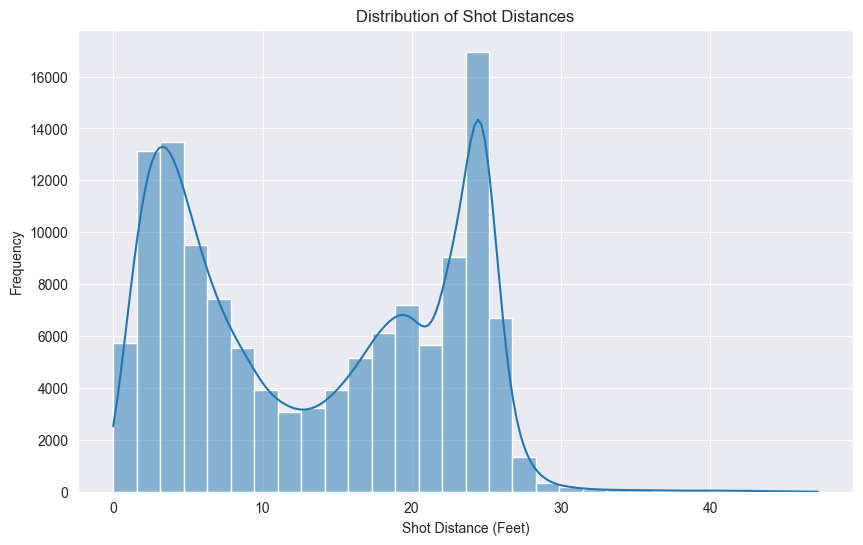

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of shot distances
plt.figure(figsize=(10, 6))
sns.histplot(data['SHOT_DIST'], bins=30, kde=True)
plt.title('Distribution of Shot Distances')
plt.xlabel('Shot Distance (Feet)')
plt.ylabel('Frequency')
plt.show()




Here we can see the distance histogram on where shots are taken. Not surprisingly, we see a ton of shot within 10 feet, as well as a bump of shots around 23 feet (The distance of the NBA 3pt line). We see how high value close to the rim shots are through that bump as well as the value of 3pt shots with the other huge mountain on the right side of the data.  

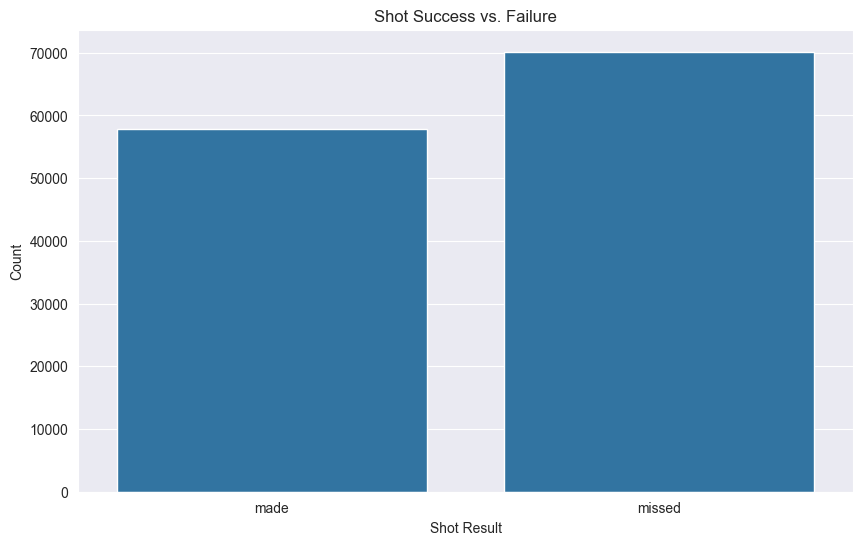

In [14]:
# Bar plot of shot success vs. failure
plt.figure(figsize=(10, 6))
sns.countplot(x='SHOT_RESULT', data=data)
plt.title('Shot Success vs. Failure')
plt.xlabel('Shot Result')
plt.ylabel('Count')
plt.show()

Here we can see a pretty simple count of made to missed shots. This does make sense as its much easier to miss a shot than make. However, these are professional athletes so the proportion is pretty close to 50/50. Lets take a better look at distance to made/miss proportion. 

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

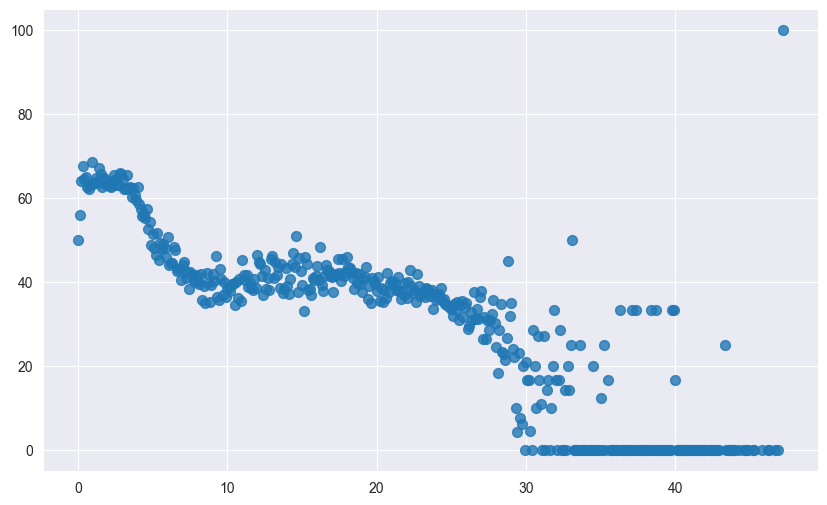

In [17]:
import matplotlib.pyplot as plt

# Calculate the total shots and made shots by shot distance
shot_data_by_dist = data.groupby('SHOT_DIST').agg(
    total_shots=('FGM', 'size'),
    made_shots=('FGM', 'sum')
).reset_index()

# Calculate the made percentage
shot_data_by_dist['made_percentage'] = (shot_data_by_dist['made_shots'] / shot_data_by_dist['total_shots']) * 100

# Smoothed line plot of made percentage by distance
plt.figure(figsize=(10, 6))
sns.regplot(x='SHOT_DIST', y='made_percentage', data=shot_data_by_dist, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Smoothed Shot Made Percentage by Distance')
plt.xlabel('Shot Distance (Feet)')
plt.ylabel('Made Percentage (%)')
plt.grid(True)
plt.show()



From this we can see that the percentage of made shots goes down the further you move away from the basket. There are some outliers here but I imagine that this is due to a low number of shots and some surprise makes that season. Lets take a look at the feature heatmap. 

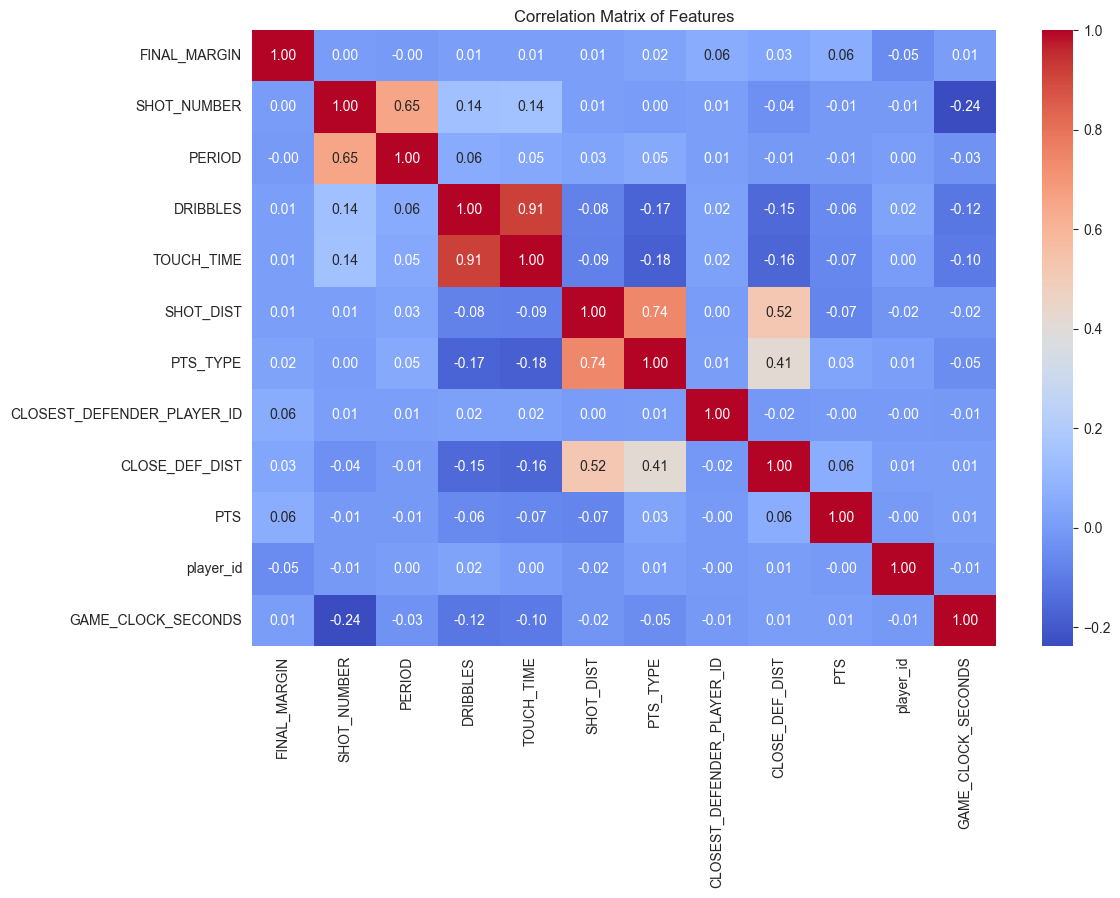

In [22]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Exclude specific columns from the numeric data
columns_to_exclude = ['GAME_ID', 'FGM']
numeric_data = numeric_data.drop(columns=columns_to_exclude, errors='ignore')

# Heatmap of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


Based on this feature heatmap matrix we can see there isnt too many heavily correlated features. You have a couple pairs like period and shot number, which makes sense as thats more of a temporal distinction, PTS_TYPE and Shot Distance which again makes sense, the farther the distance the closer you get to a 3 pt shot. I think we're looking pretty good here with not many correlated features, now lets figure out what type of model we're going to build. 

## Model Architecture

We're just going to start out with a rather basic Simple Feedforward Neural Network with the following outline:

- Input Layer: Accepts features like shot distance, player name, defender, distance, time left, etc.
- Hidden Layers: Two Fully Connected layers (Dense) with ReLU activations
- Output Layer: A single neuron with a sigmoid activation for binary classification

This model serves as a baseline (pun intended) allowing us to establish a simple comparison point. Lets make our model and do some data preprocessing and feature selection. 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Data Preparation

# Handle mixed data types by converting all object-type columns to strings before encoding
data = data.apply(lambda col: col.astype(str) if col.dtype == 'object' else col)

# Encode categorical variables
data = data.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# Select the features and target (excluding target and non-predictive columns)
X = data.drop(columns=['FGM', 'GAME_ID', 'MATCHUP', 'LOCATION','SHOT_RESULT','SHOT_DIST_BUCKET','player_name','PTS'])  # Exclude any non-predictive columns
y = data['FGM']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps and model
scaler = StandardScaler()
model = LogisticRegression()

# Recursive Feature Elimination with Preprocessing

# Create a pipeline that first scales the data and then applies RFE
rfe_pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', RFE(estimator=model, n_features_to_select=8, step=1))  # Adjust n_features_to_select as needed
])

# Fit the pipeline on the training data
rfe_pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe_pipeline.named_steps['rfe'].support_]
print("Selected features:", selected_features)


Selected features: Index(['FINAL_MARGIN', 'SHOT_NUMBER', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST',
       'PTS_TYPE', 'CLOSE_DEF_DIST', 'player_id'],
      dtype='object')


After normalizing the data, preprocessing it, and then running RFE on the features we get the top 8 features to use for the model which are shown above. Now lets take a look at some test data. 

In [38]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assume `selected_features` has been obtained from the previous RFE step
# selected_features = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'player_name_encoded', ...]

# Use only the selected features for training
X = data[selected_features].values
y = data['FGM'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Baseline model
baseline_model = Sequential([
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
baseline_history = baseline_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Baseline Test Accuracy: {baseline_test_accuracy:.2f}")


Epoch 1/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 3s 699us/step - accuracy: 0.5984 - loss: 0.6654 - val_accuracy: 0.6176 - val_loss: 0.6524
Epoch 2/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.6136 - loss: 0.6547 - val_accuracy: 0.6190 - val_loss: 0.6519
Epoch 3/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step - accuracy: 0.6174 - loss: 0.6526 - val_accuracy: 0.6171 - val_loss: 0.6517
Epoch 4/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 654us/step - accuracy: 0.6153 - loss: 0.6529 - val_accuracy: 0.6197 - val_loss: 0.6501
Epoch 5/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 652us/step - accuracy: 0.6160 - loss: 0.6525 - val_accuracy: 0.6196 - val_loss: 0.6499
Epoch 6/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step - accuracy: 0.6212 - loss: 0.6498 - val_accuracy: 0.6171 - val_loss: 0.6502
Epoch 7/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.6220 - loss: 0.6487 - val_accuracy: 0.6193 - val_loss: 0.6500
Epoch 8/20
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 0.6210 -

Now this seems like we might be overfitting the data with a 0.62 accuracy score. Thats fairly low and close to the actual percentage of missed to make shots. Lets see if our enhanced model can do better. It has this architecture:

- Input Layer: Sequences of shot attempts over time (to capture temporal dependencies)
- LSTM Layer: Captures the sequence of shots to understand the effect of previous ones
- Fully Connected Layers: Dense Layers after the LSTM to interpret the learned sequence representation
- Output Layer: Sigmoid activation for binary classification. 

LSTM's are well suited for time-series data.

In [43]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to create sequences based on GAME_ID, player_id, and shot order
def create_grouped_sequences(data, seq_length=5):
    X_seq, y_seq = [], []
    
    # Group by GAME_ID and player_name_encoded, then sort by shot number
    grouped = data.groupby(['GAME_ID', 'player_name_encoded'])
    
    for _, group in grouped:
        # Ensure the group is sorted by shot order
        group = group.sort_values(by='SHOT_NUMBER')
        
        X = group[selected_features].values
        y = group['FGM'].values
        
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Prepare the data by including the relevant features and target
data['player_name_encoded'] = LabelEncoder().fit_transform(data['player_name'])
selected_features = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'player_name_encoded']  # Example features

# Ensure 'SHOT_NUMBER' is an integer and properly represents the order
data['SHOT_NUMBER'] = data['SHOT_NUMBER'].astype(int)

# Create sequences with the updated function
X_seq, y_seq = create_grouped_sequences(data, seq_length=5)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Standardize the features (except for the sequence dimension)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Build the LSTM model
lstm_model = Sequential([
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.2f}")


Epoch 1/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5675 - loss: 0.6778 - val_accuracy: 0.6018 - val_loss: 0.6621
Epoch 2/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6036 - loss: 0.6608 - val_accuracy: 0.6023 - val_loss: 0.6614
Epoch 3/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6061 - loss: 0.6600 - val_accuracy: 0.6040 - val_loss: 0.6605
Epoch 4/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6091 - loss: 0.6564 - val_accuracy: 0.6046 - val_loss: 0.6599
Epoch 5/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6050 - loss: 0.6577 - val_accuracy: 0.6042 - val_loss: 0.6604
Epoch 6/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6044 - loss: 0.6586 - val_accuracy: 0.5994 - val_loss: 0.6618
Epoch 7/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6099 - loss: 0.6562 - val_accuracy: 0.6037 - val_loss: 0.6597
Epoch 8/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6061 - loss: 0.6577 - 

Based off this LSTM model we're getting an accuracy score of 0.60 which is a tad lower than the previous baseline model. IN this case maybe the sequential model doesnt play as much of a role here. Now lets use our advanced model which is a CNN with a LSTM hybrid. It has this architecture:

- Input layer: Includes spatial information such as distance of shot
- CNN Layers: Extract spatial features from shot location
- LSTM layer: processes the sequence of shots
- Fully Connected Layer: Dense layers that combine the spatial and temporal features
- Output layer: Sigmoid activationn for binary classification

CNN's can capture spacial relationships very well, and the LSTM helps with sequences over time. 

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import numpy as np

# Build the CNN + LSTM model
cnn_lstm_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
cnn_lstm_test_loss, cnn_lstm_test_accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print(f"CNN + LSTM Test Accuracy: {cnn_lstm_test_accuracy:.2f}")

Epoch 1/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5350 - loss: 0.6902 - val_accuracy: 0.5348 - val_loss: 0.6899
Epoch 2/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5455 - loss: 0.6881 - val_accuracy: 0.5395 - val_loss: 0.6894
Epoch 3/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5426 - loss: 0.6890 - val_accuracy: 0.5377 - val_loss: 0.6896
Epoch 4/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5463 - loss: 0.6881 - val_accuracy: 0.5386 - val_loss: 0.6899
Epoch 5/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5496 - loss: 0.6873 - val_accuracy: 0.5388 - val_loss: 0.6895
Epoch 6/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5484 - loss: 0.6878 - val_accuracy: 0.5361 - val_loss: 0.6896
Epoch 7/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5493 - loss: 0.6874 - val_accuracy: 0.5357 - val_loss: 0.6901
Epoch 8/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5485 - loss: 0.6878 - 

Here we see that we have a really low accuracy compared to the rest, this may be due to the lack of 2d spatial data on the shots in this dataset. Lets do some hyper parameter testing to see what setup is the best across all 3 models. 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Baseline Best Score:  0.5482746336027065
Baseline Best Params:  {'model__optimizer': 'rmsprop', 'model__neurons': 32, 'model__dropout_rate': 0.4}
LSTM Best Score:  0.6066211312371711
LSTM Best Params:  {'model__optimizer': 'rmsprop', 'model__lstm_units': 32, 'model__dropout_rate': 0.4, 'model__dense_neurons': 64}
CNN + LSTM Best Score:  0.5399360419251615
CNN + LSTM Best Params:  {'model__optimizer': 'adam', 'model__lstm_units': 32, 'model__dropout_rate': 0.3, 'model__dense_neurons': 32, 'model__conv_filters': 64}


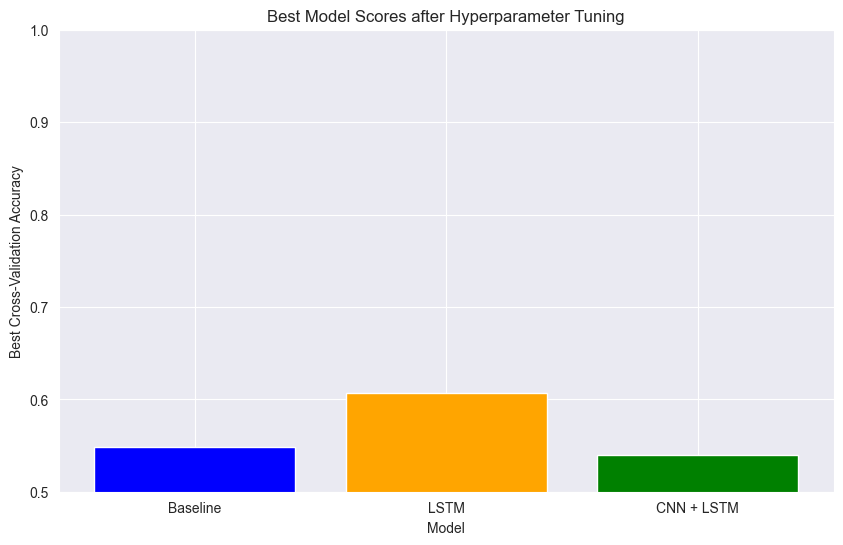

In [66]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

# Define the function to create the baseline model (2D input)
def create_baseline_model(neurons=32, dropout_rate=0.3, optimizer='adam', input_shape=None):
    model = Sequential([
        Input(shape=input_shape),  # Ensure correct input shape
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the function to create the LSTM model (3D input)
def create_lstm_model(lstm_units=64, dense_neurons=32, dropout_rate=0.3, optimizer='adam', input_shape=None):
    model = Sequential([
        Input(shape=input_shape),  # Ensure correct input shape
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(dense_neurons, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the function to create the CNN + LSTM model (3D input)
def create_cnn_lstm_model(conv_filters=32, lstm_units=64, dense_neurons=32, dropout_rate=0.3, optimizer='adam', input_shape=None):
    model = Sequential([
        Input(shape=input_shape),  # Ensure correct input shape
        Conv1D(conv_filters, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(dense_neurons, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Prepare the data (assuming selected_features have been defined earlier)
data['player_name_encoded'] = LabelEncoder().fit_transform(data['player_name'])
X_seq, y_seq = create_grouped_sequences(data, seq_length=5)  # (batch_size, timesteps, features)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
scaler = StandardScaler()

# Flatten and scale X_train and X_test for the baseline model, which requires 2D input
X_train_baseline = X_train.reshape(-1, X_train.shape[2])  # Flatten to (batch_size * timesteps, features)
X_test_baseline = X_test.reshape(-1, X_test.shape[2])  # Flatten to (batch_size * timesteps, features)

# Adjust y_train and y_test for baseline model
y_train_baseline = np.repeat(y_train, X_train.shape[1])  # Repeat labels for each timestep
y_test_baseline = np.repeat(y_test, X_test.shape[1])  # Repeat labels for each timestep

X_train_baseline = scaler.fit_transform(X_train_baseline)
X_test_baseline = scaler.transform(X_test_baseline)

# Scale X_train and X_test for the LSTM and CNN+LSTM models
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Perform hyperparameter tuning using RandomizedSearchCV
baseline_model = KerasClassifier(model=create_baseline_model, epochs=20, batch_size=32, verbose=0, input_shape=(X_train.shape[2],))
lstm_model = KerasClassifier(model=create_lstm_model, epochs=20, batch_size=32, verbose=0, input_shape=(X_train.shape[1], X_train.shape[2]))
cnn_lstm_model = KerasClassifier(model=create_cnn_lstm_model, epochs=20, batch_size=32, verbose=0, input_shape=(X_train.shape[1], X_train.shape[2]))

# Define hyperparameter grids for each model
baseline_param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop']
}

lstm_param_grid = {
    'model__lstm_units': [32, 64, 128],
    'model__dense_neurons': [32, 64],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop']
}

cnn_lstm_param_grid = {
    'model__conv_filters': [16, 32, 64],
    'model__lstm_units': [32, 64, 128],
    'model__dense_neurons': [32, 64],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop']
}

# RandomizedSearchCV for each model
baseline_search = RandomizedSearchCV(estimator=baseline_model, param_distributions=baseline_param_grid, n_iter=5, cv=3, verbose=1)
lstm_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=lstm_param_grid, n_iter=5, cv=3, verbose=1)
cnn_lstm_search = RandomizedSearchCV(estimator=cnn_lstm_model, param_distributions=cnn_lstm_param_grid, n_iter=5, cv=3, verbose=1)

# Fit the models
baseline_search.fit(X_train_baseline, y_train_baseline)  # Use baseline flattened data with adjusted labels
lstm_search.fit(X_train, y_train)
cnn_lstm_search.fit(X_train, y_train)

# Get the best scores and hyperparameters
baseline_best_score = baseline_search.best_score_
lstm_best_score = lstm_search.best_score_
cnn_lstm_best_score = cnn_lstm_search.best_score_

baseline_best_params = baseline_search.best_params_
lstm_best_params = lstm_search.best_params_
cnn_lstm_best_params = cnn_lstm_search.best_params_

# Summarize the results
print("Baseline Best Score: ", baseline_best_score)
print("Baseline Best Params: ", baseline_best_params)

print("LSTM Best Score: ", lstm_best_score)
print("LSTM Best Params: ", lstm_best_params)

print("CNN + LSTM Best Score: ", cnn_lstm_best_score)
print("CNN + LSTM Best Params: ", cnn_lstm_best_params)

# Plot the results
model_names = ['Baseline', 'LSTM', 'CNN + LSTM']
best_scores = [baseline_best_score, lstm_best_score, cnn_lstm_best_score]

plt.figure(figsize=(10, 6))
plt.bar(model_names, best_scores, color=['blue', 'orange', 'green'])
plt.title('Best Model Scores after Hyperparameter Tuning')
plt.xlabel('Model')
plt.ylabel('Best Cross-Validation Accuracy')
plt.ylim(0.5, 1.0)
plt.show()


## Results and Analysis

Based off our hyperparameter tuning for these 3 models, it looks like the best model was the LSTM model with these parameters:

 {'model__optimizer': 'rmsprop', 'model__lstm_units': 32, 'model__dropout_rate': 0.4, 'model__dense_neurons': 64}
 
#### What worked and what didnt

Some takeaways from this hyperparameter tuning are that the baseline model served as a good reference since it performed adequately. However, its simplicity limited it ability to capture complex temporal dependencies. The LSTM model was the best model outperforming both others, The choice of a slightly higher number of dense neurons and the use of rmsprop for optimization proved helpful with performance. Lastly the CNN + LSTM proves here that adding complexity doesnt always lead to better performance. 

#### Troubleshooting

Some issues we faced was that we had to ensure the input shapes matched the model architecture at sever different junctures. This was very important for LSTM and CNN + LSTM which required 3d input. Due to the performance difference of rmsprop we can see that training instability was an issue as well. Lastly overfitting was closely monitored through validation performance and mitigated through dropout and early stopping.

#### Hyperparameter Optimization Procedure Summary

For the tuning we used RandomizedSearchCV to explore different combinations efficiently. The parameters we tuned for each model are as follows:

- Baseline
  - number of neurons
  - dropout rate
  - optimizer
- LSTM
  - Number of LSTM units
  - dense neurons
  - dropout rate
  - optimizer
- CNN + LSTM
  - number of convolutional filters
  - LSTM units
  - dense neurons
  - dropout rate
  - optimizer

## Conclusion

The LSTM model with rmsprop optimizer, 32 LSTM units, 64 dense neurons, and a 0.4 dropout rate provided the best performance. This highlights the importance of carefully selecting the model architecture and hyperparameters to match the task. While the CNN + LSTM hybrid model introduced additional complexity, it did not lead to improved performance, suggesting that simpler, more targeted models can sometimes be more effective. Future work could involve exploring alternative architectures like GRU or Transformers, implementing data augmentation, or employing ensemble methods to further enhance performance.


Lastly for some fun, I wanted to take a look at the buzzer beaters. 

In [76]:
best_lstm_model = lstm_search.best_estimator_.model_

In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Reload the data
data = pd.read_csv('./data/shot_logs.csv')

# Ensure all columns are uppercase
data.columns = data.columns.str.upper()

# Preprocess the data
if 'PLAYER_NAME' in data.columns:
    data['PLAYER_NAME'] = pd.factorize(data['PLAYER_NAME'])[0]

# Select features
features = ['PLAYER_NAME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK']  # Example feature names
X = data[features].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape to match LSTM input expectations (batch_size, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Adding a single timestep dimension

# Make predictions using the best LSTM model
# Predict the probabilities of making the shot
y_pred_probs = best_lstm_model.predict(X_reshaped)

#  Add the predicted probabilities as a column in the DataFrame
data['PREDICTED_MAKE_PROB'] = y_pred_probs.squeeze()

# Filter for shots that were actually made (assuming 'FGM' indicates made shots, where 1 = made, 0 = missed)
made_shots = data[data['FGM'] == 1]

# Apply additional filters
# 1. Period is the maximum for each GAME_ID
max_period_condition = made_shots.groupby('GAME_ID')['PERIOD'].transform('max') == made_shots['PERIOD']

# 2. Absolute value of the final margin is less than or equal to the absolute value of PTS_TYPE
final_margin_condition = made_shots['FINAL_MARGIN'].abs() <= made_shots['PTS_TYPE'].abs()

# 3. Game clock is 0
game_clock_zero_condition = made_shots['GAME_CLOCK'] == '0:00'

# 4. Filter for rows where 'W' equals 'W' (assuming 'W' is a column indicating a win)
w_condition = made_shots['W'] == 'W'

# Combine all conditions
combined_conditions = max_period_condition & final_margin_condition & game_clock_zero_condition & w_condition

# Apply the combined conditions to filter the data
filtered_made_shots = made_shots[combined_conditions]

# Step 7: Sort by the lowest predicted make probability
lowest_prob_makes = filtered_made_shots.sort_values(by='PREDICTED_MAKE_PROB', ascending=True)

# Step 8: Display the shots with the lowest make probability
print("Shots with the lowest predicted make probability that were actually made, "
      "with period as max for GAME_ID, absolute FINAL_MARGIN <= absolute PTS_TYPE, GAME_CLOCK = 0, and 'W' = 'W':")
print(lowest_prob_makes[['GAME_ID', 'PLAYER_ID', 'PREDICTED_MAKE_PROB']])


4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2s 494us/step
Shots with the lowest predicted make probability that were actually made, with period as max for GAME_ID, absolute FINAL_MARGIN <= absolute PTS_TYPE, GAME_CLOCK = 0, and 'W' = 'W':
        GAME_ID  PLAYER_ID  PREDICTED_MAKE_PROB
29836  21400755     203076             0.473228
53729  21400898     203092             0.473228
81693  21400118     201584             0.473228


These game ID's refer to the follwing:

https://www.youtube.com/watch?v=kmar9bLehVY

https://www.youtube.com/watch?v=XOlZ6cfimoo

https://www.youtube.com/watch?v=L_TLXGh5ayY
